Setup & Configuration

In [1]:
%matplotlib inline

import subprocess, sys, os, json, time, math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from types import SimpleNamespace
import pyarrow.parquet as pq

In [2]:
# ============================================================
# CONFIGURATION
# ============================================================
dataset_dir = os.path.abspath("dataset")
mouse = "M1199_PAG"
stride = 4
window_size = 108  # 36, 108, ou 252

json_file = f"{mouse}.json"
parquet_file = f"{mouse}_stride{stride}_win{window_size}_test.parquet"


---## 0.5 Téléchargement du dataset (Google Drive → dataset/)

In [3]:
if not os.path.isdir(dataset_dir) or len(os.listdir(dataset_dir)) == 0:
    print("Téléchargement du dataset depuis Google Drive...")
    try:
        import gdown
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "gdown", "-q"])
        import gdown

    os.makedirs(dataset_dir, exist_ok=True)
    gdown.download_folder(
        "https://drive.google.com/drive/folders/1A-4s5IB11Vo1fWViFYjNB0f_4oBXCApQ",
        output=dataset_dir,
        quiet=False,
    )
    print(f"\n✅ Dataset téléchargé dans {dataset_dir}")
else:
    print(f"Dataset déjà présent dans {dataset_dir}")

print(f"Contenu : {os.listdir(dataset_dir)}")

Dataset déjà présent dans /Users/ippo/Downloads/hackathon/theta-gang-master/dataset
Contenu : ['M1199_PAG_stride4_win108_test.parquet', '.DS_Store', 'M1199_PAG.json']


In [4]:
# Charger les paramètres depuis le JSON
with open(os.path.join(dataset_dir, json_file), "r") as f:
    params_raw = json.load(f)

params = SimpleNamespace(**params_raw)
params.nChannelsPerGroup = []
for g in range(params.nGroups):
    params.nChannelsPerGroup.append(params_raw[f"group{g}"]["nChannels"])

print(f"nGroups = {params.nGroups}")
print(f"nChannelsPerGroup = {params.nChannelsPerGroup}")

nGroups = 4
nChannelsPerGroup = [6, 4, 6, 4]


---## 1. Chargement des données (Parquet → RAM)On charge le Parquet directement en mémoire et on l'utilise tel quel. **Pas de conversion .pt, pas de TensorFlow.**

In [5]:
parquet_path = os.path.join(dataset_dir, parquet_file)
print(f"Lecture de {parquet_path}...")
t0 = time.time()
df = pq.ParquetFile(parquet_path).read().to_pandas()
print(f"Chargé en {time.time() - t0:.1f}s — {len(df)} lignes, {len(df.columns)} colonnes")

Lecture de /Users/ippo/Downloads/hackathon/theta-gang-master/dataset/M1199_PAG_stride4_win108_test.parquet...
Chargé en 24.9s — 62257 lignes, 18 colonnes


In [6]:
class ParquetSpikeDataset(torch.utils.data.Dataset):
    """Dataset PyTorch qui lit directement depuis un DataFrame Parquet en RAM.
    
    NOUVEAU v2 : retourne aussi indexInDat pour le positional encoding temporel.
    """

    def __init__(self, dataframe, params, indices=None):
        self.df = dataframe
        self.params = params
        self.n_groups = params.nGroups
        self.indices = indices if indices is not None else np.arange(len(dataframe))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        row = self.df.iloc[self.indices[idx]]
        out = {}

        # Position cible (x, y)
        pos = np.array(row["pos"], dtype=np.float32)
        target = torch.tensor(pos[:2], dtype=torch.float32)

        # Groupes : séquence chronologique
        groups = np.array(row["groups"], dtype=np.int64)
        out["groups"] = torch.from_numpy(groups)

        # NOUVEAU : timestamps de chaque spike dans la séquence
        # indexInDat / 20000 = temps en secondes
        # On normalise en temps relatif au sein de la fenêtre (0 = début, 1 = fin)
        if "indexInDat" in row.index and row["indexInDat"] is not None:
            idx_in_dat = np.array(row["indexInDat"], dtype=np.float32)
            if len(idx_in_dat) > 0:
                t_min = idx_in_dat[idx_in_dat >= 0].min() if np.any(idx_in_dat >= 0) else 0
                t_max = idx_in_dat[idx_in_dat >= 0].max() if np.any(idx_in_dat >= 0) else 1
                t_range = max(t_max - t_min, 1.0)
                # Temps relatif : 0 = premier spike, 1 = dernier spike
                spike_times = np.where(idx_in_dat >= 0, (idx_in_dat - t_min) / t_range, -1.0)
            else:
                spike_times = np.full(len(groups), -1.0)
        else:
            spike_times = np.full(len(groups), -1.0)
        out["spike_times"] = torch.tensor(spike_times, dtype=torch.float32)

        # Waveforms par shank (identique à v1)
        for g in range(self.n_groups):
            nCh = self.params.nChannelsPerGroup[g]
            raw = np.array(row[f"group{g}"], dtype=np.float32).reshape(-1)

            if raw.shape[0] > 0 and raw.shape[0] % (nCh * 32) == 0:
                waveforms = raw.reshape(-1, nCh, 32)
                non_zero_mask = ~np.all(waveforms == 0, axis=(1, 2))
                waveforms = waveforms[non_zero_mask]

                old_to_new = np.zeros(len(non_zero_mask) + 1, dtype=np.int32)
                new_i = 1
                for oi in range(len(non_zero_mask)):
                    if non_zero_mask[oi]:
                        old_to_new[oi + 1] = new_i
                        new_i += 1

                indices_col = f"indices{g}"
                if indices_col in row.index:
                    raw_idx = np.array(row[indices_col], dtype=np.int32).reshape(-1)
                    raw_idx = np.clip(raw_idx, 0, len(old_to_new) - 1)
                    out[f"indices{g}"] = torch.from_numpy(old_to_new[raw_idx])
                else:
                    out[f"indices{g}"] = torch.zeros(len(groups), dtype=torch.long)

                out[f"group{g}"] = torch.from_numpy(waveforms)
            else:
                out[f"group{g}"] = torch.zeros((0, nCh, 32), dtype=torch.float32)
                out[f"indices{g}"] = torch.zeros(len(groups), dtype=torch.long)

        return out, target

In [7]:
def collate_fn(batch):
    """Pad les séquences de longueurs variables.
    NOUVEAU v2 : pad aussi spike_times."""
    inputs_list, targets_list = zip(*batch)
    B = len(inputs_list)

    max_seq = max(b["groups"].shape[0] for b in inputs_list)
    max_spikes = {}
    for g in range(params.nGroups):
        max_spikes[g] = max(max(b[f"group{g}"].shape[0] for b in inputs_list), 1)

    result = {}

    # Groups — pad avec -1
    groups = torch.full((B, max_seq), -1, dtype=torch.long)
    for i, b in enumerate(inputs_list):
        L = b["groups"].shape[0]
        groups[i, :L] = b["groups"]
    result["groups"] = groups
    result["mask"] = (groups != -1).float()

    # NOUVEAU : spike_times — pad avec -1 (= pas de spike)
    spike_times = torch.full((B, max_seq), -1.0, dtype=torch.float32)
    for i, b in enumerate(inputs_list):
        L = b["spike_times"].shape[0]
        spike_times[i, :L] = b["spike_times"]
    result["spike_times"] = spike_times

    # Indices — pad avec 0
    for g in range(params.nGroups):
        idx = torch.zeros((B, max_seq), dtype=torch.long)
        for i, b in enumerate(inputs_list):
            L = b[f"indices{g}"].shape[0]
            idx[i, :L] = b[f"indices{g}"]
        idx = idx.clamp(max=max_spikes[g])
        result[f"indices{g}"] = idx

    # Waveforms — pad avec des zéros
    for g in range(params.nGroups):
        nCh = params.nChannelsPerGroup[g]
        ms = max_spikes[g]
        wf = torch.zeros((B, ms, nCh, 32), dtype=torch.float32)
        for i, b in enumerate(inputs_list):
            n = b[f"group{g}"].shape[0]
            if n > 0:
                wf[i, :n] = b[f"group{g}"]
        result[f"group{g}"] = wf

    result["pos"] = torch.stack(targets_list)
    return result

In [9]:
# Speed mask : filtrer les exemples où la souris bouge
speed_col = "speedMask"
if speed_col in df.columns:
    def parse_speed(val):
        if isinstance(val, (bytes, np.bytes_)):
            return val == b"\x01"
        return bool(val)
    speed_mask = df[speed_col].apply(parse_speed).values
    valid_indices = np.where(speed_mask)[0]
    print(f"SpeedMask: {len(valid_indices)}/{len(df)} exemples rapides ({100*len(valid_indices)/len(df):.1f}%)")
else:
    valid_indices = np.arange(len(df))

rng = np.random.RandomState(42)
shuffled = rng.permutation(valid_indices)
n_train = int(0.9 * len(shuffled))

train_ds = ParquetSpikeDataset(df, params, indices=shuffled[:n_train])
val_ds = ParquetSpikeDataset(df, params, indices=shuffled[n_train:])

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        collate_fn=collate_fn, num_workers=0)

print(f"Train: {len(train_ds)} exemples, {len(train_loader)} batches")
print(f"Val  : {len(val_ds)} exemples, {len(val_loader)} batches")

SpeedMask: 22974/62257 exemples rapides (36.9%)
Train: 20676 exemples, 324 batches
Val  : 2298 exemples, 36 batches


---## 2. Exploration des donnéesDirectement depuis le DataFrame en mémoire.

In [10]:
# Déjà en mémoire — pas besoin de recharger
print(f"{len(df)} exemples en mémoire")
print(f"Colonnes : {list(df.columns)}")

62257 exemples en mémoire
Colonnes : ['group0', 'group1', 'group2', 'group3', 'groups', 'indexInDat', 'length', 'pos', 'pos_index', 'time', 'time_behavior', 'speedMask', 'indexInDat_raw', 'indices0', 'zeroForGather', 'indices1', 'indices2', 'indices3']


### 2.1 Structure d'un exemple

In [11]:
row = df.iloc[0]
print("Clés disponibles :")
for key in row.index:
    val = row[key]
    if isinstance(val, (list, np.ndarray)):
        arr = np.array(val)
        print(f"  {key:20s} → array shape={arr.shape}  dtype={arr.dtype}")
    else:
        print(f"  {key:20s} → {type(val).__name__} = {val}")

Clés disponibles :
  group0               → array shape=(2880,)  dtype=float32
  group1               → array shape=(2688,)  dtype=float32
  group2               → array shape=(3456,)  dtype=float32
  group3               → array shape=(2432,)  dtype=float32
  groups               → array shape=(73,)  dtype=int64
  indexInDat           → array shape=(73,)  dtype=int64
  length               → array shape=(1,)  dtype=int64
  pos                  → array shape=(4,)  dtype=float64
  pos_index            → array shape=(1,)  dtype=int64
  time                 → array shape=(1,)  dtype=float32
  time_behavior        → array shape=(1,)  dtype=float32
  speedMask            → array shape=(1,)  dtype=bool
  indexInDat_raw       → array shape=(73,)  dtype=int64
  indices0             → array shape=(73,)  dtype=int32
  zeroForGather        → array shape=(64,)  dtype=float32
  indices1             → array shape=(73,)  dtype=int32
  indices2             → array shape=(73,)  dtype=int32
  indices3  

### 2.2 Positions cibles

In [12]:
positions = np.stack(df["pos"].values)[:, :2]
times = df["time"].values.astype(np.float32)

print(f"Shape positions : {positions.shape}")
for i, axis in enumerate(["x", "y"]):
    v = positions[:, i]
    print(f"  {axis}: min={v.min():.4f}  max={v.max():.4f}  mean={v.mean():.4f}  std={v.std():.4f}")

Shape positions : (62257, 2)
  x: min=0.0036  max=0.9896  mean=0.5177  std=0.3304
  y: min=-0.0051  max=1.0095  mean=0.5858  std=0.3370


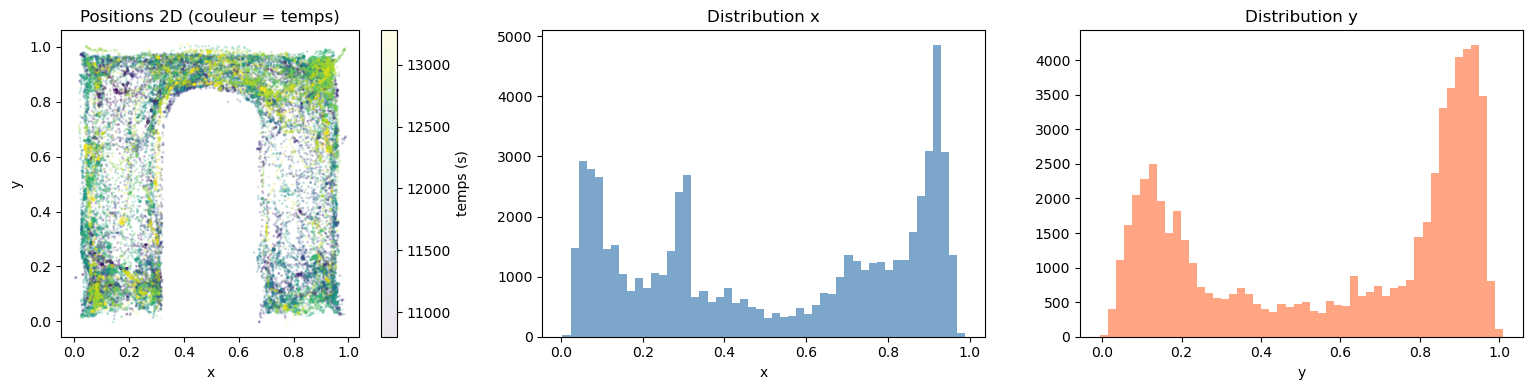

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Positions 2D
ax = axes[0]
sc = ax.scatter(positions[:, 0], positions[:, 1], s=1, alpha=0.1, c=times, cmap="viridis")
plt.colorbar(sc, ax=ax, label="temps (s)")
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.set_title("Positions 2D (couleur = temps)")
ax.set_aspect("equal")

# Distribution x
ax = axes[1]
ax.hist(positions[:, 0], bins=50, color="steelblue", alpha=0.7)
ax.set_xlabel("x"); ax.set_title("Distribution x")

# Distribution y
ax = axes[2]
ax.hist(positions[:, 1], bins=50, color="coral", alpha=0.7)
ax.set_xlabel("y"); ax.set_title("Distribution y")

plt.tight_layout()
plt.show()

### 2.3 Séquences de spikes

In [14]:
seq_lengths = np.array([np.sum(np.array(g) != -1) for g in df["groups"].values])

print(f"Longueur séquences :")
print(f"  min={seq_lengths.min()}, max={seq_lengths.max()}, mean={seq_lengths.mean():.1f}, median={np.median(seq_lengths):.0f}")

Longueur séquences :
  min=2, max=190, mean=54.8, median=53


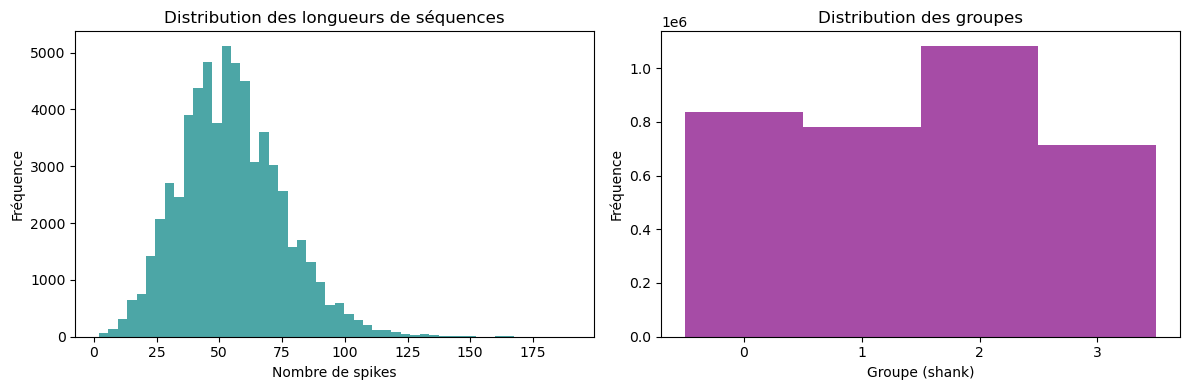

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution longueurs
ax = axes[0]
ax.hist(seq_lengths, bins=50, color="teal", alpha=0.7)
ax.set_xlabel("Nombre de spikes"); ax.set_ylabel("Fréquence")
ax.set_title("Distribution des longueurs de séquences")

# Distribution des groupes
all_groups = np.concatenate([np.array(g)[np.array(g) >= 0] for g in df["groups"].values])
ax = axes[1]
ax.hist(all_groups, bins=np.arange(params.nGroups + 1) - 0.5, color="purple", alpha=0.7)
ax.set_xlabel("Groupe (shank)"); ax.set_ylabel("Fréquence")
ax.set_title("Distribution des groupes")
ax.set_xticks(range(params.nGroups))

plt.tight_layout()
plt.show()

### 2.4 Waveforms

In [16]:
# Stats globales sur les waveforms
for g in range(params.nGroups):
    nCh = params.nChannelsPerGroup[g]
    sample_wf = np.array(df.iloc[0][f"group{g}"], dtype=np.float32)
    if sample_wf.shape[0] > 0 and sample_wf.shape[0] % (nCh * 32) == 0:
        wf = sample_wf.reshape(-1, nCh, 32)
        print(f"Group {g}: {wf.shape[0]} spikes × {nCh} canaux × 32 échantillons | range=[{wf.min():.1f}, {wf.max():.1f}]")
    else:
        print(f"Group {g}: pas de données")

Group 0: 15 spikes × 6 canaux × 32 échantillons | range=[-203.0, 129.8]
Group 1: 21 spikes × 4 canaux × 32 échantillons | range=[-66.2, 24.7]
Group 2: 18 spikes × 6 canaux × 32 échantillons | range=[-44.5, 37.0]
Group 3: 19 spikes × 4 canaux × 32 échantillons | range=[-89.6, 32.4]


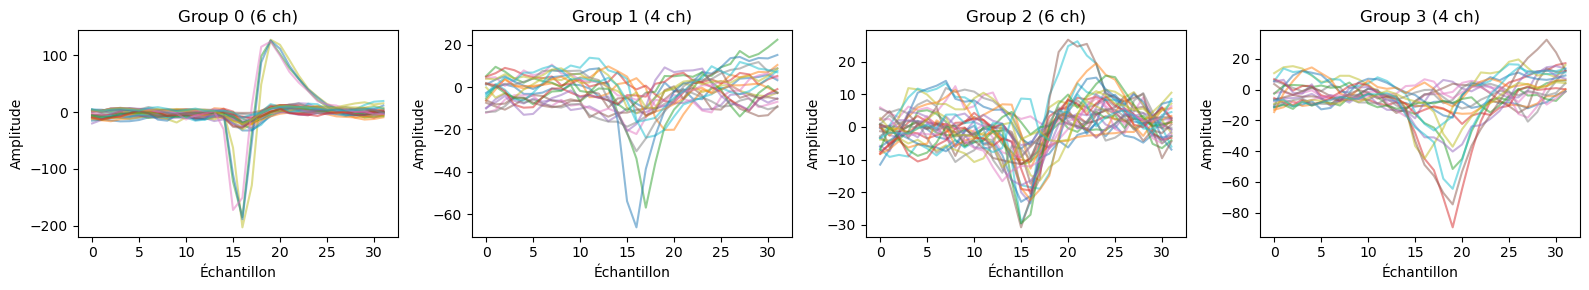

In [17]:
# Visualiser des waveforms
fig, axes = plt.subplots(1, params.nGroups, figsize=(4 * params.nGroups, 3))
if params.nGroups == 1:
    axes = [axes]
for g in range(params.nGroups):
    nCh = params.nChannelsPerGroup[g]
    wf = np.array(df.iloc[0][f"group{g}"], dtype=np.float32)
    if wf.shape[0] > 0 and wf.shape[0] % (nCh * 32) == 0:
        wf = wf.reshape(-1, nCh, 32)
        ax = axes[g]
        for s in range(min(5, wf.shape[0])):
            for ch in range(nCh):
                ax.plot(wf[s, ch], alpha=0.5)
        ax.set_title(f"Group {g} ({nCh} ch)")
        ax.set_xlabel("Échantillon"); ax.set_ylabel("Amplitude")
plt.tight_layout()
plt.show()

---## 3. Training PyTorch (Transformer v2)100% PyTorch à partir d'ici. Le Transformer remplace le average pooling de v1.

### 3.1 Dataset & DataLoader

In [18]:
# Train/Val déjà créés dans la section 1
# On vérifie juste que tout est OK
batch = next(iter(train_loader))
print("Clés du batch :")
for k, v in batch.items():
    print(f"  {k:20s} → {v.shape}  dtype={v.dtype}")

Clés du batch :
  groups               → torch.Size([64, 117])  dtype=torch.int64
  mask                 → torch.Size([64, 117])  dtype=torch.float32
  spike_times          → torch.Size([64, 117])  dtype=torch.float32
  indices0             → torch.Size([64, 117])  dtype=torch.int64
  indices1             → torch.Size([64, 117])  dtype=torch.int64
  indices2             → torch.Size([64, 117])  dtype=torch.int64
  indices3             → torch.Size([64, 117])  dtype=torch.int64
  group0               → torch.Size([64, 33, 6, 32])  dtype=torch.float32
  group1               → torch.Size([64, 26, 4, 32])  dtype=torch.float32
  group2               → torch.Size([64, 35, 6, 32])  dtype=torch.float32
  group3               → torch.Size([64, 23, 4, 32])  dtype=torch.float32
  pos                  → torch.Size([64, 2])  dtype=torch.float32


### 3.2 Modèle — Transformer + Positional Encoding Temporel

In [19]:
class ContinuousPositionalEncoding(nn.Module):
    """
    Positional encoding basé sur le VRAI temps du spike (pas juste sa position dans la séquence).
    
    Contrairement au PE classique des Transformers (qui encode la position 0, 1, 2, 3...),
    ici on encode le temps continu du spike dans la fenêtre (entre 0.0 et 1.0).
    
    Chaque spike reçoit un vecteur PE calculé avec des sinusoïdes à différentes fréquences,
    ce qui permet au Transformer de savoir QUAND chaque spike a eu lieu.
    
    Un spike à t=0.1 et un spike à t=0.9 auront des encodages très différents,
    même s'ils viennent du même neurone.
    """

    def __init__(self, d_model, max_freq_scale=1000.0):
        super().__init__()
        self.d_model = d_model
        # Fréquences log-espacées pour les sinusoïdes
        # Basses fréquences → patterns lents, hautes fréquences → timing fin
        freqs = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(max_freq_scale) / d_model)
        )
        self.register_buffer("freqs", freqs)

    def forward(self, spike_times):
        """
        spike_times: (B, L) — temps normalisé [0, 1] de chaque spike, -1 = padding
        Retourne: (B, L, d_model) — encodage temporel
        """
        # Remplacer -1 (padding) par 0 — le mask s'en occupera
        t = spike_times.clamp(min=0).unsqueeze(-1)  # (B, L, 1)
        # Calcul des sinusoïdes : sin(t * freq) et cos(t * freq)
        angles = t * self.freqs.unsqueeze(0).unsqueeze(0)  # (B, L, d_model//2)
        pe = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)  # (B, L, d_model)
        return pe

In [20]:
class SpikeTransformerDecoder(nn.Module):
    """
    Décodeur de position v2 — avec Transformer et encodage temporel.
    
    Différences avec v1 (SpikeDecoder) :
    - NOUVEAU : positional encoding temporel basé sur indexInDat
    - NOUVEAU : Transformer encoder (self-attention) au lieu du average pooling
      → le modèle apprend les dépendances séquentielles entre spikes
      → "si neurone A tire AVANT neurone B, la souris va de A vers B"
    - NOUVEAU : embedding du groupe (quel shank) ajouté aux features
    
    Le reste (embedding des waveforms, null spike trick, gather) est identique à v1.
    """

    def __init__(self, params, n_features=128, n_heads=4, n_layers=2,
                 dropout=0.1, mode="nll"):
        super().__init__()
        self.params = params
        self.n_features = n_features
        self.n_groups = params.nGroups
        self.mode = mode

        # 1. Embedding des waveforms par shank (comme v1)
        self.embedders = nn.ModuleList()
        for g in range(self.n_groups):
            n_flat = params.nChannelsPerGroup[g] * 32
            self.embedders.append(nn.Sequential(
                nn.Linear(n_flat, n_features),
                nn.ReLU(),
                nn.Linear(n_features, n_features),  # une couche de plus que v1
            ))

        # 2. NOUVEAU : embedding du groupe (quel shank a tiré)
        # Permet au Transformer de distinguer les spikes venant de shanks différents
        self.group_embedding = nn.Embedding(self.n_groups + 1, n_features, padding_idx=0)
        # +1 car on utilise 0 comme padding, les vrais groupes sont décalés de +1

        # 3. NOUVEAU : positional encoding temporel continu
        self.temporal_pe = ContinuousPositionalEncoding(n_features)

        # 4. Projection pour combiner waveform + group + temps
        self.input_proj = nn.Sequential(
            nn.Linear(n_features * 3, n_features),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        # 5.Transformer encoder (self-attention)
        # Chaque spike peut "regarder" tous les autres spikes de la fenêtre
        # et apprendre quels patterns séquentiels sont informatifs
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=n_features,
            nhead=n_heads,
            dim_feedforward=n_features * 4,
            dropout=dropout,
            batch_first=True,  # (B, L, F) et pas (L, B, F)
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=n_layers,
        )

        # 6. Tête de sortie (identique à v1)
        if mode == "nll":
            self.head = nn.Sequential(
                nn.Linear(n_features, n_features),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(n_features, 4),  # mu_x, mu_y, log_sigma_x, log_sigma_y
            )
        else:
            self.head = nn.Sequential(
                nn.Linear(n_features, n_features),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(n_features, 2),  # x, y
            )

    def forward(self, batch):
        groups_seq = batch["groups"]       # (B, L)
        mask = batch["mask"]               # (B, L)
        spike_times = batch["spike_times"] # (B, L) — NOUVEAU
        B, L = groups_seq.shape

        # === Étape 1 : embedding des waveforms (identique à v1) ===
        gathered_list = []
        for g in range(self.n_groups):
            wf = batch[f"group{g}"]
            n_spikes = wf.shape[1]
            nCh = self.params.nChannelsPerGroup[g]

            wf_flat = wf.reshape(B, n_spikes, nCh * 32)
            emb = self.embedders[g](wf_flat)

            null = torch.zeros(B, 1, self.n_features, device=emb.device)
            full_emb = torch.cat([null, emb], dim=1)

            raw_idx = batch[f"indices{g}"]
            safe_idx = raw_idx.clamp(min=0, max=n_spikes)
            idx = safe_idx.unsqueeze(-1).expand(-1, -1, self.n_features)
            gathered = torch.gather(full_emb, dim=1, index=idx)
            gathered_list.append(gathered)

        # Stack + sélection shank actif (identique à v1)
        stacked = torch.stack(gathered_list, dim=2)
        g_clamped = groups_seq.clamp(min=0)
        one_hot = F.one_hot(g_clamped, num_classes=self.n_groups).float()
        waveform_features = (stacked * one_hot.unsqueeze(-1)).sum(dim=2)  # (B, L, n_features)

        # === Étape 2 : NOUVEAU — embedding du groupe ===
        # Décaler de +1 pour que le padding (-1 → 0) aille sur padding_idx
        group_emb = self.group_embedding(g_clamped + 1)  # (B, L, n_features)

        # === Étape 3 : NOUVEAU — positional encoding temporel ===
        time_emb = self.temporal_pe(spike_times)  # (B, L, n_features)

        # === Étape 4 : combiner les 3 sources d'information ===
        # waveform_features : QUOI (la forme du spike → identité du neurone)
        # group_emb : OÙ dans le cerveau (quel shank)
        # time_emb : QUAND dans la fenêtre (timing précis)
        combined = torch.cat([waveform_features, group_emb, time_emb], dim=-1)  # (B, L, 3*n_features)
        seq_features = self.input_proj(combined)  # (B, L, n_features)

        # === Étape 5 : NOUVEAU — Transformer encoder ===
        # Le mask empêche le Transformer de regarder les positions de padding
        # key_padding_mask = True pour les positions à ignorer
        key_padding_mask = (mask == 0)  # (B, L) — True = padding
        transformer_out = self.transformer(
            seq_features,
            src_key_padding_mask=key_padding_mask,
        )  # (B, L, n_features)

        # === Étape 6 : masked average pooling (comme v1, mais après le Transformer) ===
        # Le Transformer a enrichi chaque spike avec le contexte des autres spikes
        # Le pooling résume le tout en un seul vecteur
        mask_exp = mask.unsqueeze(-1)
        total = (transformer_out * mask_exp).sum(dim=1)
        count = mask_exp.sum(dim=1).clamp(min=1e-7)
        context = total / count  # (B, n_features)

        # === Étape 7 : sortie ===
        output = self.head(context)

        if self.mode == "nll":
            mu = output[:, :2]
            log_sigma = output[:, 2:].clamp(-5, 5)
            sigma = torch.exp(log_sigma)
            return mu, sigma
        else:
            return output

In [21]:
def gaussian_nll_loss(mu, sigma, target):
    """
    Negative Log-Likelihood d'une gaussienne diagonale.
    
    NLL = 0.5 * [ log(2π) + 2·log(σ) + ((target - μ) / σ)² ]
    
    - mu proche de target ET sigma petit → NLL basse (récompense)
    - mu loin de target ET sigma petit → NLL très haute (pénalité)
    - sigma grand → NLL modérée (le modèle avoue qu'il ne sait pas)
    
    Peut devenir NÉGATIVE quand le modèle est très précis et confiant.
    """
    log_sigma = torch.log(sigma)
    nll = 0.5 * (
        np.log(2 * np.pi)
        + 2 * log_sigma
        + ((target - mu) / sigma) ** 2
    )
    return nll.sum(dim=-1).mean()

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

N_FEATURES = 128   # plus large que v1 (64) pour donner de la capacité au Transformer
N_HEADS = 4        # nombre de têtes d'attention
N_LAYERS = 2       # profondeur du Transformer
DROPOUT = 0.1
MODE = "nll"

model = SpikeTransformerDecoder(
    params,
    n_features=N_FEATURES,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    dropout=DROPOUT,
    mode=MODE,
).to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Mode: {MODE}, Features: {N_FEATURES}, Heads: {N_HEADS}, Layers: {N_LAYERS}")
print(f"Paramètres: {n_params:,}")

Device: cpu
Mode: nll, Features: 128, Heads: 4, Layers: 2
Paramètres: 611,972


### 3.3 Entraînement

In [33]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss, n = 0.0, 0
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        target = batch["pos"]

        if model.mode == "nll":
            mu, sigma = model(batch)
            loss = gaussian_nll_loss(mu, sigma, target)
        else:
            pred = model(batch)
            loss = F.mse_loss(pred, target)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += loss.item() * len(target)
        n += len(target)
    return total_loss / n


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_mse, total_nll, n = 0.0, 0.0, 0
    all_mu, all_sigma, all_targets = [], [], []

    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        target = batch["pos"]

        if model.mode == "nll":
            mu, sigma = model(batch)
            nll = gaussian_nll_loss(mu, sigma, target)
            total_nll += nll.item() * len(target)
            all_sigma.append(sigma.cpu())
        else:
            mu = model(batch)

        mse = F.mse_loss(mu, target)
        total_mse += mse.item() * len(target)
        n += len(target)
        all_mu.append(mu.cpu())
        all_targets.append(target.cpu())

    preds = torch.cat(all_mu)
    targets = torch.cat(all_targets)
    sigmas = torch.cat(all_sigma) if all_sigma else None

    return {
        "mse": total_mse / n,
        "nll": total_nll / n ,
        "preds": preds,
        "targets": targets,
        "sigmas": sigmas,
    }

In [ ]:
# Hyperparamètres
EPOCHS = 15
LR = 3e-4  

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

train_losses = []
val_mse_losses = []
val_nll_losses = []
best_val = float("inf")

print(f"{'='*60}")
print(f"Training: {EPOCHS} epochs, LR={LR}, batch_size={BATCH_SIZE}")
print(f"{'='*60}\n")

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_results = evaluate(model, val_loader)
    elapsed = time.time() - t0

    val_mse = val_results["mse"]
    val_nll = val_results["nll"]

    train_losses.append(train_loss)
    val_mse_losses.append(val_mse)
    if val_nll is not None:
        val_nll_losses.append(val_nll)

    track_metric = val_nll if val_nll is not None else val_mse
    old_lr = optimizer.param_groups[0]["lr"]
    scheduler.step(track_metric)
    new_lr = optimizer.param_groups[0]["lr"]

    marker = ""
    if track_metric < best_val:
        best_val = track_metric
        torch.save(model.state_dict(), "best_model_v2.pt")
        marker = " ★"

    nll_str = f" | nll={val_nll:.4f}" if val_nll is not None else ""
    lr_info = f" (lr: {old_lr:.1e} → {new_lr:.1e})" if new_lr != old_lr else ""
    print(f"Epoch {epoch:3d}/{EPOCHS} | train={train_loss:.6f} | mse={val_mse:.6f}{nll_str}{marker}{lr_info} ({elapsed:.1f}s)")

Training: 15 epochs, LR=0.0003, batch_size=64

Epoch   1/15 | train=-1.204873 | mse=0.030930 | nll=-0.6585 ★ (327.3s)
Epoch   2/15 | train=-1.282322 | mse=0.030572 | nll=-0.8537 ★ (240.7s)
Epoch   3/15 | train=-1.359563 | mse=0.029875 | nll=-0.6708 (228.4s)
Epoch   4/15 | train=-1.442062 | mse=0.028875 | nll=-0.9423 ★ (261.1s)
Epoch   5/15 | train=-1.529660 | mse=0.025419 | nll=-0.8542 (306.5s)
Epoch   6/15 | train=-1.585857 | mse=0.027394 | nll=-0.8514 (253.7s)
Epoch   7/15 | train=-1.650226 | mse=0.025419 | nll=-0.5826 (236.7s)
Epoch   8/15 | train=-1.692681 | mse=0.026932 | nll=-0.7039 (319.1s)
Epoch   9/15 | train=-1.745202 | mse=0.022813 | nll=-1.1663 ★ (241.0s)
Epoch  10/15 | train=-1.833693 | mse=0.022386 | nll=-0.8212 (240.1s)
Epoch  11/15 | train=-1.830626 | mse=0.022346 | nll=-0.9076 (273.3s)
Epoch  12/15 | train=-1.891194 | mse=0.019710 | nll=-0.9805 (254.9s)


### 3.4 Résultats

/var/folders/pv/fql_h__s6_j6_jjpd2gr9kk40000gn/T/ipykernel_11021/2503112472.py:32: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(1, len(val_nll_losses))


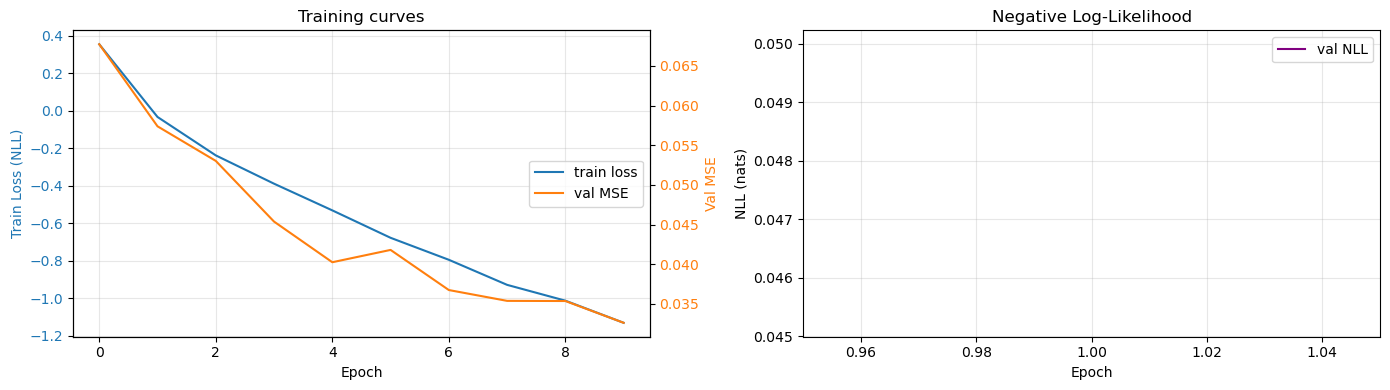

In [32]:
# Courbes de loss
fig, axes = plt.subplots(1, 2 if val_nll_losses else 1, figsize=(14 if val_nll_losses else 8, 4))
if not isinstance(axes, np.ndarray):
    axes = [axes]

# Graphe 1 : train loss et val MSE sur des axes séparés (échelles très différentes)
ax1 = axes[0]
ax1.plot(train_losses, label="train loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Train Loss (NLL)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()  # deuxième axe Y pour la val MSE
ax2.plot(val_mse_losses, label="val MSE", color="tab:orange")
ax2.set_ylabel("Val MSE", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

ax1.set_title("Training curves")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")

# Graphe 2 : NLL avec axe X correct
if val_nll_losses:
    ax = axes[1]
    epochs = list(range(1, len(val_nll_losses) + 1))
    ax.plot(epochs, val_nll_losses, label="val NLL", color="purple")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("NLL (nats)")
    ax.set_title("Negative Log-Likelihood")
    ax.set_xlim(1, len(val_nll_losses))
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# Charger le meilleur modèle et évaluer
model.load_state_dict(torch.load("best_model_v2.pt", weights_only=True))
val_results = evaluate(model, val_loader)

preds = val_results["preds"]
targets = val_results["targets"]
sigmas = val_results["sigmas"]

distances = torch.sqrt(((preds - targets) ** 2).sum(dim=1))
print(f"{'='*60}")
print(f"RÉSULTATS FINAUX (v2 Transformer)")
print(f"{'='*60}")
print(f"Erreur euclidienne (val) :")
print(f"  mean   = {distances.mean():.4f}")
print(f"  median = {distances.median():.4f}")
print(f"  std    = {distances.std():.4f}")

print(f"\nMSE (val)  = {val_results['mse']:.6f}")

if val_results["nll"] is not None:
    print(f"NLL (val)  = {val_results['nll']:.4f}")

    print(f"\nConfiance (sigma) :")
    print(f"  sigma_x : mean={sigmas[:, 0].mean():.4f}  std={sigmas[:, 0].std():.4f}")
    print(f"  sigma_y : mean={sigmas[:, 1].mean():.4f}  std={sigmas[:, 1].std():.4f}")

    within_1sigma = (torch.abs(preds - targets) < sigmas).all(dim=1).float().mean()
    within_2sigma = (torch.abs(preds - targets) < 2 * sigmas).all(dim=1).float().mean()
    print(f"\nCalibration :")
    print(f"  Cible dans ±1σ : {100*within_1sigma:.1f}% (idéal ≈ 46%)")
    print(f"  Cible dans ±2σ : {100*within_2sigma:.1f}% (idéal ≈ 86%)")

RÉSULTATS FINAUX (v2 Transformer)
Erreur euclidienne (val) :
  mean   = 0.2037
  median = 0.1628
  std    = 0.1541

MSE (val)  = 0.032617


---## 4. Visualisation

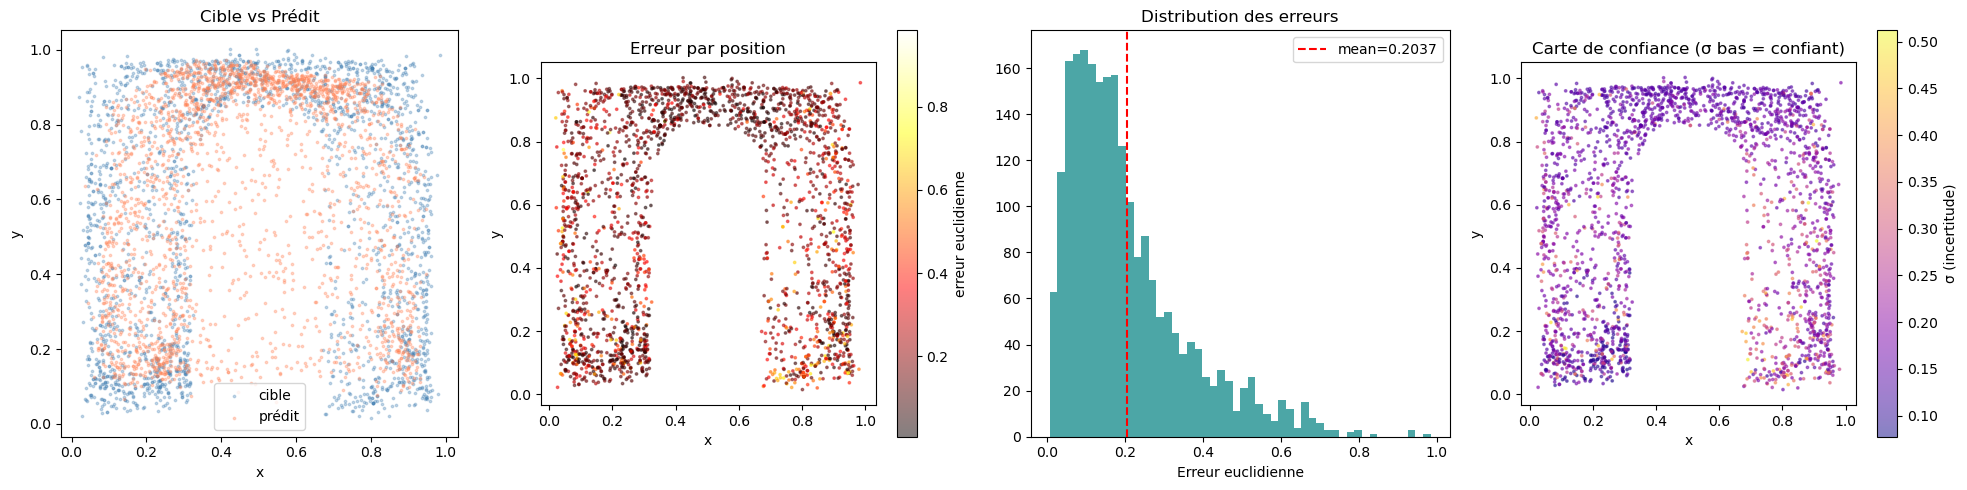

In [30]:
preds_np = preds.numpy()
targets_np = targets.numpy()
dist_np = distances.numpy()

fig, axes = plt.subplots(1, 4 if sigmas is not None else 3,
                         figsize=(20 if sigmas is not None else 16, 5))

ax = axes[0]
ax.scatter(targets_np[:, 0], targets_np[:, 1], s=3, alpha=0.3, label="cible", c="steelblue")
ax.scatter(preds_np[:, 0], preds_np[:, 1], s=3, alpha=0.3, label="prédit", c="coral")
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.set_title("Cible vs Prédit")
ax.legend(); ax.set_aspect("equal")

ax = axes[1]
sc = ax.scatter(targets_np[:, 0], targets_np[:, 1], s=3, c=dist_np, cmap="hot", alpha=0.5)
plt.colorbar(sc, ax=ax, label="erreur euclidienne")
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.set_title("Erreur par position")
ax.set_aspect("equal")

ax = axes[2]
ax.hist(dist_np, bins=50, color="teal", alpha=0.7)
ax.axvline(dist_np.mean(), color="red", ls="--", label=f"mean={dist_np.mean():.4f}")
ax.set_xlabel("Erreur euclidienne")
ax.set_title("Distribution des erreurs")
ax.legend()

if sigmas is not None:
    ax = axes[3]
    sigma_np = sigmas.numpy()
    sigma_mean = np.sqrt(sigma_np[:, 0]**2 + sigma_np[:, 1]**2)
    sc = ax.scatter(targets_np[:, 0], targets_np[:, 1], s=3, c=sigma_mean, cmap="plasma", alpha=0.5)
    plt.colorbar(sc, ax=ax, label="σ (incertitude)")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title("Carte de confiance (σ bas = confiant)")
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()



#  Pistes d'amélioration du modèle

---

##  Waveforms
- Remplacer la couche **Linear** par une **Conv1D** pour l'embedding  
- Permet de mieux capturer la structure temporelle locale des signaux  

---

##  Fonction de perte (NLL)
- Utiliser une **Mixture of Gaussians (MDN)**  
- Permet des **prédictions multimodales**  
- Modélise mieux l'incertitude  

---

##  Architecture
- Tester des alternatives au **Transformer** :
  - **GRU**
  - **Mamba**
- Comparer :
  - Performance  
  - Stabilité d'entraînement  
  - Coût computationnel  

---

##  Attention
- Visualiser les **poids d’attention**  
- Identifier quels *spikes* influencent le plus la prédiction  
- Améliorer l’interprétabilité du modèle  

---

##  Pre-training
- Implémenter du **masked spike modeling**
  - Masquer certains spikes  
  - Les prédire pendant l’entraînement  
- Inspiré du masked language modeling  
- Objectif : apprendre de meilleures représentations  